<a href="https://colab.research.google.com/github/lifeisbeautifu1/deep-learning/blob/main/Diffusion_forward_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [19]:
# Linear variance schedule
def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  return betas

In [20]:
# Cosine schedule from https://arxiv.org/abs/2102.09672
def cosine_schedule(num_timesteps, s=0.008):
  def f(t):
    return torch.cos((t / num_timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
  x = torch.linspace(0, num_timesteps, num_timesteps + 1)
  alphas_cumprod = f(x) / f(torch.tensor([0]))
  betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
  betas = torch.clip(betas, 0.0001, 0.999)
  return betas

In [21]:
def sample_by_t(tensor_to_sample, timesteps, x_shape):
  batch_size = timesteps.shape[0]
  sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
  sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
  return sampled_tensor.to(timesteps.device)

In [48]:
num_timesteps = 500
betas_t = linear_schedule(num_timesteps)

alphas_t = 1.0 - betas_t
alphas_bar_t = torch.cumprod(alphas_t, dim=0)
alphas_bar_t_minus_1 = torch.cat((torch.tensor([0]), alphas_bar_t[:-1]))
one_over_sqrt_alphas_t = 1. / torch.sqrt(alphas_t)
sqrt_alphas_bar_t = torch.sqrt(alphas_bar_t)
sqrt_1_minus_alphas_bar_t = torch.sqrt(1. - alphas_bar_t)
# the variance of q(xₜ₋₁ | xₜ, x₀) as in part 3
posterior_variance = (1. - alphas_bar_t_minus_1) / (1. - alphas_bar_t) * betas_t

In [49]:
def sample_q(x0, t, noise=None):
  if noise is None:
    noise = torch.randn_like(x0)

  sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x0.shape)
  sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x0.shape)

  x_t = sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise
  return x_t

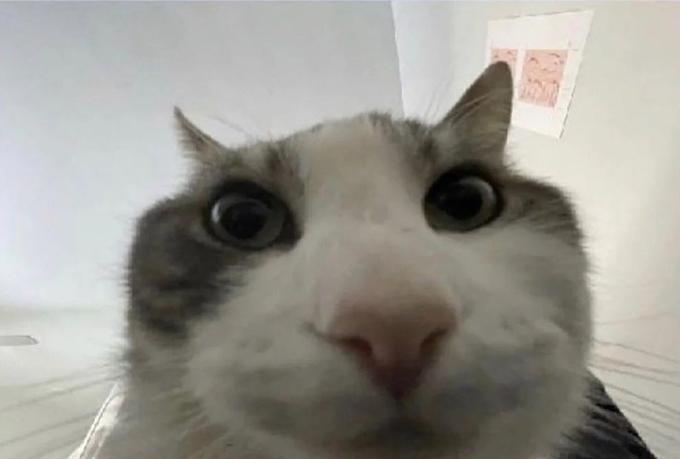

In [50]:
import requests
from PIL import Image

url = 'https://static.wikia.nocookie.net/silly-cat/images/4/4f/Wire_Cat.png/revision/latest?cb=20231001190626'
image_raw_data = requests.get(url, stream=True).raw
image = Image.open(image_raw_data)
image

In [51]:
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize, Normalize

image_size = 128
transform = Compose([
  Resize(image_size),  # resize smaller edge to image_size
  CenterCrop(image_size),  # make a square image with size image_size
  ToTensor(),  # convert to tensor with shape CHW and values in the range [0, 1]
  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # set the values to the range [-1, 1]
])

In [52]:
from torchvision.transforms import ToPILImage

reverse_transform_pil = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
  ToPILImage()
])

reverse_transform_tensor = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
])

In [53]:
def get_noisy_image(x0, t, transform=reverse_transform_pil):
  x_noisy = sample_q(x0, t)
  noise_image = transform(x_noisy.squeeze())
  return noise_image

In [54]:
import matplotlib.pyplot as plt

def show_noisy_images(noisy_images):
  """
  Show and return a grid of noisy images where
  the rows are different images, and the columns
  are the noisy images in different timesteps.

  Args:
    noisy_images (list[list[PIL]]): a list with a lists of images
      with noise from different timesteps.
  """
  num_of_image_sets = len(noisy_images)
  num_of_images_in_set = len(noisy_images[0])
  image_size = noisy_images[0][0].size[0]

  full_image = Image.new('RGB', (image_size * num_of_images_in_set + (num_of_images_in_set - 1), image_size * num_of_image_sets + (num_of_image_sets - 1)))
  for set_index, image_set in enumerate(noisy_images):
    for image_index, image in enumerate(image_set):
      full_image.paste(image, (image_index * image_size + image_index, set_index * image_size + set_index))

  plt.imshow(full_image)
  plt.axis('off')
  return full_image

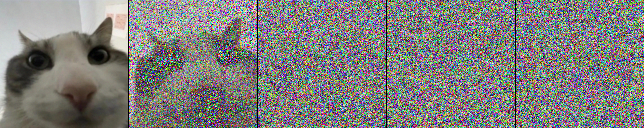

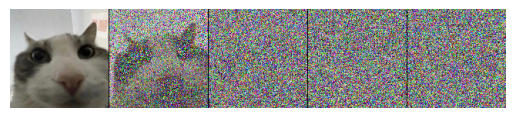

In [55]:
show_noisy_images([[get_noisy_image(transform(image), torch.tensor([t * 100])) for t in range(5)]])